Studente: Francesco Romeo

Matricola: 634705

__Laboratorio di Web Scraping__





# Importazioni librerie
Dopo aver importato le librerie, andiamo a settare le __mining pools__ che ci interessano e settiamo la __profondità massima__.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import Request, urlopen
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import random
import time
import seaborn as sns
import networkx as nx
import pygraphviz as pgv
import re 

MiningPools = ["DeepBit.net", "Eligius.st", "BTCGuild.com", "BitMinter.com"]
k = 10

# Pulizia dataset
Prendiamo i dataset e procediamo a levare gli input/output che non sono presenti nella tabella transazioni, cosi facendo mi assicuro che
tutte le transazioni siano collegate ad un blocco valido e dentro il dataset.

In [2]:
transactions = pd.read_csv("DataSets/transactions.csv", names = ["timestamp", "blockId", "txId", "isCoinbase", "fee"])
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit='s')

inputs = pd.read_csv("DataSets/inputs.csv", names= ["txId", "prevTxId" ,"prevTxPos"])
outputs = pd.read_csv("DataSets/outputs.csv", names = ["txId", "position", "addressId", "amount", "scripttype"])
inputs = inputs[inputs['txId'].isin(transactions['txId'])]
outputs = outputs[outputs['txId'].isin(transactions['txId'])]

mapping = pd.read_csv("DataSets/mapAddr2Ids8708820.csv", names=["hash","addressId"])

Poi procediamo ad eliminare gli input duplicati, assieme agli output con amount <= 0

In [3]:
# Identifica e filtra gli input duplicati
duplicates_mask = inputs.duplicated(subset=['prevTxId', 'prevTxPos'], keep=False)
inputs = inputs[~duplicates_mask]
outputs = outputs[outputs['amount'] > 0]

# Analisi dati della blockchain
Dobbiamo studiare l'andamento dei dati presenti dentro il dataset, per raggiungere questo obiettivo, implementeremo diverse funzioni specifiche.

## map_scripttype_to_value
Questa funzione restituisce la dimensione in byte corrispondente al tipo di script fornito.
Se non conosce il tipo, ritornerà 0.

## sizedf
Accetta in input un intervallo di date.
Successivamente seleziona le transazioni che rientrano nel periodo specificato.
Raggruppa e somma gli input e gli output delle transazioni ed esegue un merge delle tabelle contenenti gli input e gli output.
Calcola la dimensione delle transazioni moltiplicando il numero di input per 40 e il numero di output per 9 (entrambi valori fissi); Poi stampa la dimensione totale delle transazioni e la media della colonna fee.
Infine divide i dati per settimane e li raggruppa, calcolando la dimensione totale delle transazioni e la media delle fee settimanali, e ritorna questi dati.

In [4]:
def map_scripttype_to_value(scripttype):
    scripttype_to_value = {1: 153, 2: 180, 3: 291}
    return scripttype_to_value.get(scripttype, 0)


def sizedf(start_date, end_date):
    # Prendo le transazioni nel periodo di interesse direttamente dalla selezione
    selected_transactions = transactions[(transactions['timestamp'] >= start_date) & (transactions['timestamp'] <= end_date)]
    

    #Raggruppa inputs e outputs e calcola la somma
    inputs_count = inputs.groupby('txId').size().reset_index(name='input_count')
    outputs['valore'] = outputs['scripttype'].map(map_scripttype_to_value)
    outputs_agg = outputs.groupby('txId').agg(output_count=('valore', 'size'), somma=('valore', 'sum')).reset_index()

    # Merge dei dati filtrati, inputs e outputs
    merged_data = selected_transactions.merge(inputs_count, on='txId').merge(outputs_agg, on='txId') 
    merged_data['size'] = 40 * merged_data['input_count'] + 9 * merged_data['output_count'] + merged_data['somma']
    
    size = merged_data['size'].sum()
    print("La dimensione delle transazioni è: ", size)    
    media_fee = merged_data['fee'].mean()
    print("La media della colonna 'fee' è:", media_fee)

    merged_data['week'] = merged_data['timestamp'].dt.to_period('W')
    weekly_stats = merged_data.groupby('week').agg(total_transaction_size=('size', 'sum'), average_fee=('fee', 'mean')).reset_index()
    return weekly_stats


# Chiamata alla funzione principale
weekly_stats= sizedf('2009-01-03 17:15:05', '2012-12-31 11:52:37')

La dimensione delle transazioni è:  5389603366
La media della colonna 'fee' è: 95883.58315735446


# Grafico dati settimanali
Converto le settimane in oggetti timestamp per un'analisi temporale più accurata.
Successivamente, elaboreremo i dati settimanali, convertendo le commissioni medie (average fee) da satoshi a bitcoin.
Con questi dati creeremo un grafico, impostando la dimensione, i colori del testo e le etichette pertinenti.
Individueremo i valori massimi per i due grafici (congestione e commissioni medie), applicando uno stile diverso per renderli facilmente riconoscibili. 
Per il plot della congestione, il tutto viene rappresentato in byte.
Con entrambi usiamo la scala logaritmica perchè consente di visualizzare una vasta gamma di valori.

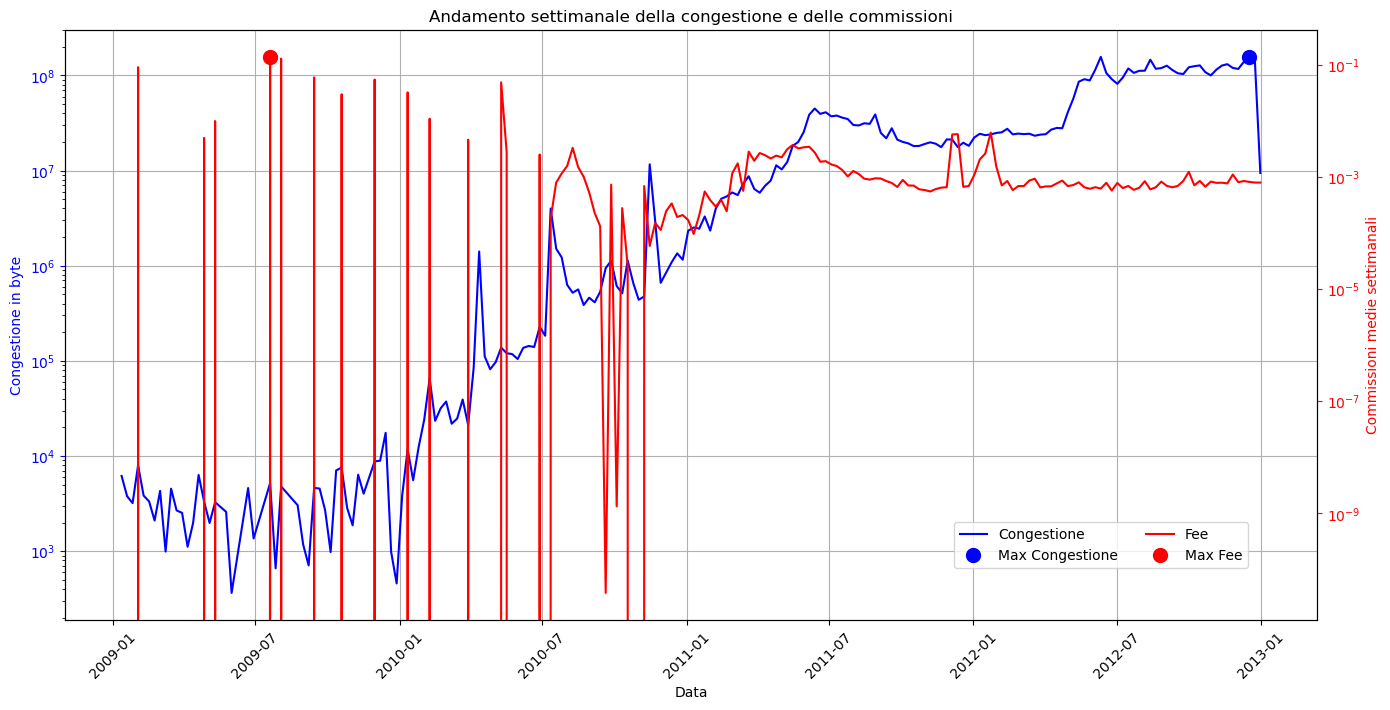

In [5]:
# Converti i periodi in oggetti Timestamp
weeks_timestamp = weekly_stats['week'].dt.to_timestamp()

# Dati settimanali
total_transaction_size = weekly_stats['total_transaction_size']
average_fee = weekly_stats['average_fee'] / 100000000

# Creazione del plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot della dimensione totale delle transazioni sull'asse sinistro
ax1.plot(weeks_timestamp, total_transaction_size, color='b', label='Congestione')

# Individua i valori massimi per la dimensione totale delle transazioni
max_total_size_index = total_transaction_size.idxmax()

# Evidenzia il valore massimo con un diverso stile di marker
ax1.plot(weeks_timestamp[max_total_size_index], total_transaction_size[max_total_size_index], marker='o', markersize=10, color='b', linestyle='None', label='Max Congestione')

# Aggiunta di titoli e etichette per l'asse sinistro
ax1.set_xlabel('Data')
ax1.set_ylabel('Congestione in byte', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(True)

ax1.set_yscale('log')
plt.xticks(rotation=45)

# Plot della media delle commissioni settimanali sull'asse destro
ax2 = ax1.twinx()
ax2.plot(weeks_timestamp, average_fee, color='r', label='Fee')

# Individua i valori massimi per la media delle commissioni settimanali
max_avg_fee_index = average_fee.idxmax()

# Evidenzia il valore massimo con un diverso stile di marker
ax2.plot(weeks_timestamp[max_avg_fee_index], average_fee[max_avg_fee_index], marker='o', markersize=10, color='r', linestyle='None', label='Max Fee')

ax2.set_ylabel('Commissioni medie settimanali', color='r')
ax2.tick_params('y', colors='r')
ax2.set_yscale('log')
fig.legend(loc='lower right', bbox_to_anchor=(0.90, 0.20), ncol=2)

# Mostra il plot
fig.tight_layout()
plt.title('Andamento settimanale della congestione e delle commissioni')
plt.show()


Dal grafico vediamo due serie di dati, la congestione totale della blockchain (blu) e e le fee medie per transazioni (rosso).
Sono entrambe su una scala settimanale che va da gennaio 2009 a gennaio 2013 (dove solo gennaio 2009 è compreso).

Possiamo notare come le fee aumentino di pari passo all'aumento della congestione, questo ci fa capire che quando la congestione della
rete aumenta, gli utenti tendono a pagare fee più alte.
Cosi facendo si garantiscono che le loro transazioni siano processate più velocemente.

Per quanto riguarda la congestione, possiamo vedere come abbia una crescita esponenziale, questo può indicare un aumento nell'adozione della moneta, oppure periodi di intenso uso o trading.

__Quindi possiamo dire dal grafico che quando la rete è congestionata, gli utenti pagano più fee per assicurarsi che le loro transazioni vengano confermate più velocemente.__

# Grafico dell'andamento degli scripttype
Per prima cosa faccio il merge tra il dataframe __transaction__ e __outputs__ e la conversione delle date in anni e settimane.
Successivamente, calcoleremo le statistiche per anno e settimana, raggruppando i dati e conteggiando i vari tipi di script (scripttype). 
Infine visualizzeremo i risultati con grafici, usando una scala logaritmica per migliorare la leggibilità dei dati.

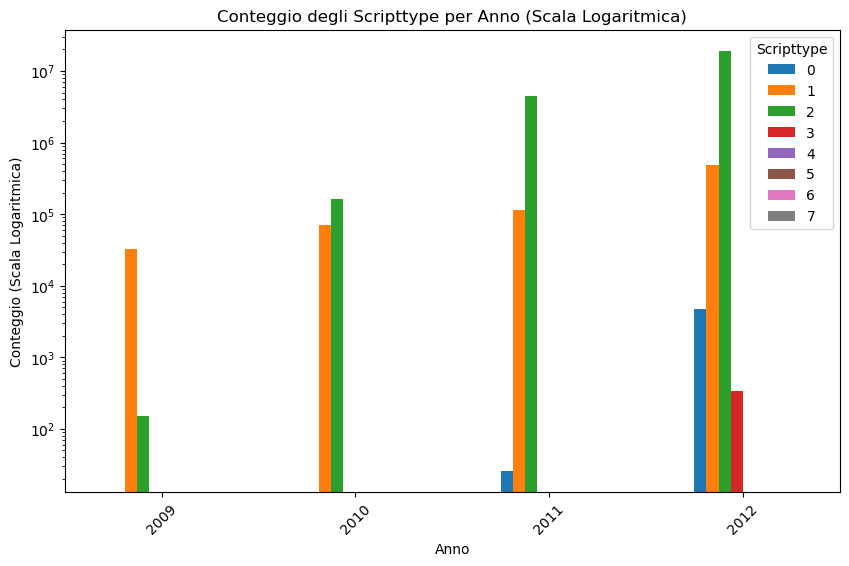

<Figure size 1000x600 with 0 Axes>

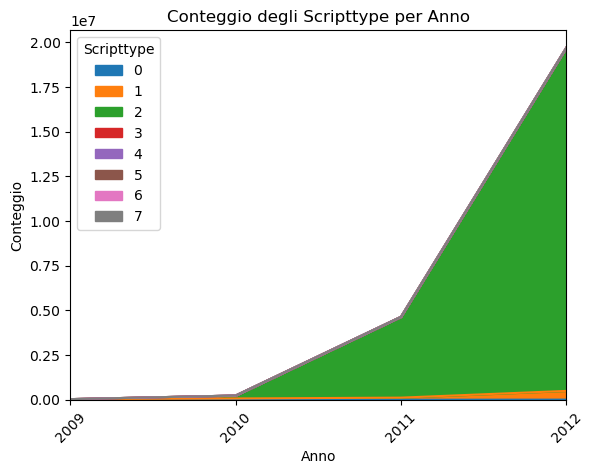

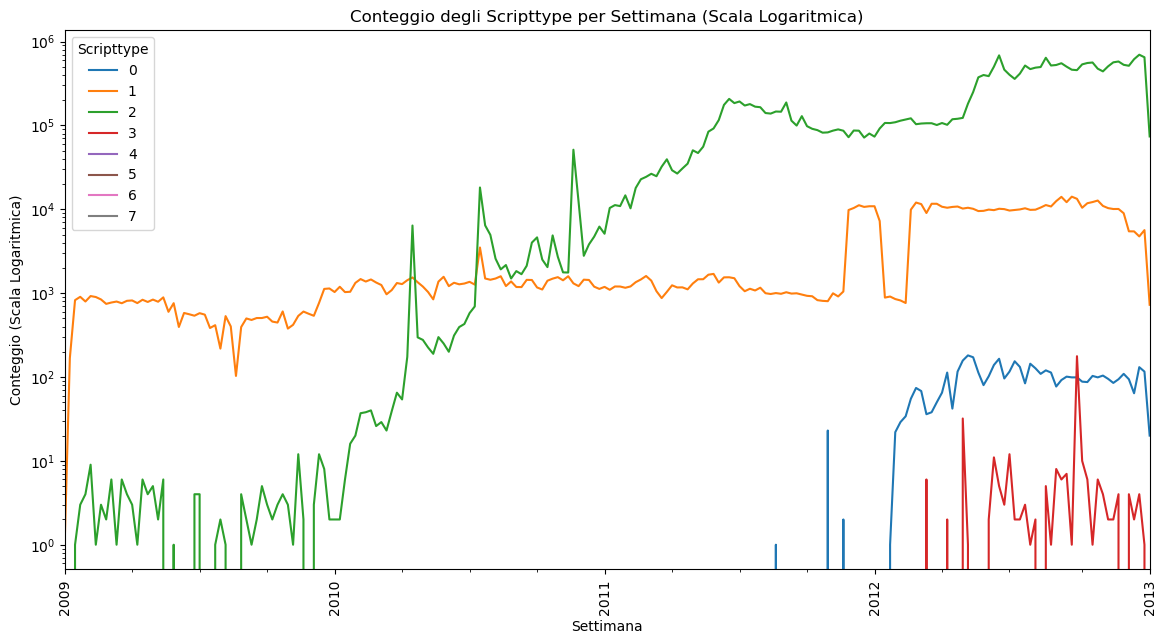

In [17]:
# Merge dei dati
merged_out = pd.merge(transactions, outputs, on='txId', how='inner')
merged_out['year'] = merged_out['timestamp'].dt.to_period('Y')
merged_out['week'] = merged_out['timestamp'].dt.to_period('W')

# Statistiche per anno
year_stats = merged_out.groupby('year')
year_scripttype_counts = year_stats['scripttype'].value_counts().unstack(fill_value=0)
year_scripttype_counts = year_scripttype_counts.reindex(columns=range(8), fill_value=0)

# Visualizzazione con Pandas e scala logaritmica
year_scripttype_counts.plot.bar(figsize=(10, 6), logy=True)  #ho mersso barh al psoto di bar
plt.title('Conteggio degli Scripttype per Anno (Scala Logaritmica)')
plt.xlabel('Anno')
plt.ylabel('Conteggio (Scala Logaritmica)')
plt.xticks(rotation=45)
plt.legend(title='Scripttype')
plt.show()


# Visualizzazione con Matplotlib
plt.figure(figsize=(10, 6))
year_scripttype_counts.plot(kind='area', stacked=True)
plt.title('Conteggio degli Scripttype per Anno')
plt.xlabel('Anno')
plt.ylabel('Conteggio')
plt.xticks(rotation=45)
plt.legend(title='Scripttype')
plt.show()


# Raggruppa i dati per settimana e scripttype
weekly_scripttype_counts = merged_out.groupby(['week', 'scripttype']).size().unstack(fill_value=0)
weekly_scripttype_counts = weekly_scripttype_counts.reindex(columns=range(8), fill_value=0)


# Creazione del plot settimanale con Pandas e scala logaritmica
weekly_scripttype_counts.plot.line(figsize=(14, 7), logy=True)
plt.xlabel('Settimana')
plt.ylabel('Conteggio (Scala Logaritmica)')
plt.xticks(rotation=90)
plt.legend(title='Scripttype')
fig.tight_layout()
plt.title('Conteggio degli Scripttype per Settimana (Scala Logaritmica)')
plt.show()

Parliamo un attimo di questi script:

- __Unknown__: Script non identificabili/standardizzati.
  
- __P2PK - Pay to Public Key__: uno dei primi metodi utilizzati per trasferire bitcoin, paga direttamente a una chiave pubblica.

  
- __P2PKH - Pay to Public Key Hash__: la versione più sicura di P2PK, paga a un hash della chiave pubblica.

  
- __P2SH - Pay to Script Hash__: Permette l'uso di script complessi senza doverli includere direttamente nella transazione, migliorando   l'efficienza, paga a un hash di uno script

  
- __RETURN__: Questo tipo di script consente di includere dati arbitrari in una transazione senza che questi possano essere spesi, e quindi non è necessario salvare i dati nel database UTXO.

  
- __EMPTY__: è usato per rappresentare script vuoti. Non sono validi per le transazioni standard e sono generalmente considerati errori o casi speciali.

- __P2WPKH - Pay to Witness Public Key Hash)__: è una versione segwit (Segregated Witness) di P2PKH. Migliora l'efficienza e la sicurezza riducendo la dimensione della transazione e migliorando la malleabilità.

  
- __P2WSH - Pay to Witness Script Hash__ : Questo tipo di script è una versione segwit di P2SH. Consente script complessi con i vantaggi di segwit.

  

Dal grafico si può vedere l’evoluzione dei metodi di scripting nelle transazioni da gennaio 2009 a dicembre 2012 (usando una scala logaitmica).
È evidente come, all'inizio lo script più utilizzato era il __P2PK__, uno dei più semplici e diretti.
Tuttavia, verso la fine del 2010, viene sostituito da __P2PKH__.
Questo perche __P2PKH__ offre una maggiore sicurezza nascondendo la chiave pubblica fino al momento effettivo della spesa, dimostrando come gli utenti iniziassero a cercare garanzie, preoccupandosi per la privacy e la sicurezza delle chiavi pubbliche.

E possibile notare anche la presenza di picchi per gli script di tipo __Unknown__, che potrebbero indicare la presenza di transazioni che non rientrano negli standard piu comuni, o anche degli esperimenti con dei nuovi script.
Questo fenomeno indica una ricerca di innovazione, mirata ad esplorare i limiti della blockchain.

Infine verso l'inizio del 2012 possiamo vedere come inizia a crescere __P2SH__, questo grazie al fatto che supporta script più complessi, come quelli utilizzati per i conti multisignature.

Nel complesso, il secondo grafico mostra chiaramente che, durante il periodo analizzato, lo script più utilizzato è stato il P2PKH, dimostrando la preferenza degli utenti per soluzioni che offrono maggiore sicurezza.

# Analisi delle mining pools
Ci viene chiesto di implementare uno scraper, il cui scopo è quello di deanominizzare una lista di indirizzi presenti nel dataset.
Il processo prevede l'utilizzo di proxy per evitare il blocco IP e mantenere anonime le richieste.

## generate_proxies
Prima di tutto, definiamo la funzione __generate_proxies__, che crea una lista di proxy.
Questo ci permette di distribuire le richieste su più indirizzi IP, riducendo il rischio di essere bloccati.
Utilizziamo la libreria UserAgent per generare casualmente un user agent, simulando una richiesta da un browser reale.

## get_service_name_walletexplorer
La funzione __get_service_name_walletexplorer__ ha lo scopo di recuperare gli indirizzi dei servizi associati a un nome specifico su WalletExplorer.
Questa funzione è progettata per gestire le limitazioni imposte dal sito, come i blocchi IP, e per navigare attraverso le pagine dei risultati per ottenere tutti i dati disponibili.

In [7]:
def generate_proxies():
    proxies.clear() # Svuoto la lista dei proxy (nel caso la funzione venga chiamata più volte non si vogliono avere duplicati)
    proxies_req = Request('https://www.sslproxies.org/')
    proxies_req.add_header('User-Agent', ua.random)
    proxies_doc = urlopen(proxies_req).read().decode('utf8')
    soup = BeautifulSoup(proxies_doc, 'html.parser')
    proxies_table = soup.find('table', class_='table table-striped table-bordered')
    # Salvo i proxy nella lista proxies
    for row in proxies_table.tbody.find_all('tr'):
        td = row.find_all('td')
        proxies.append({
        'ip':   td[0].string,
        'port': td[1].string})
 
def get_service_name_walletexplorer(address, proxies, page=1):
    url = f"https://www.walletexplorer.com/wallet/{address}/addresses?page={page}"
    original_proxy_count = len(proxies)
    results = []

    while True:
        if len(proxies) == 0:
            print(f"Numero massimo di proxy bloccati raggiunto. Terminazione. ({original_proxy_count})")
            raise StopIteration
        proxy = random.choice(proxies)
        user_agent = ua.random

        try:
            headers = {'User-Agent': user_agent}
            response = requests.get(url, headers=headers, proxies=proxy)
            soup = BeautifulSoup(response.text, 'html.parser')
            if response.text.startswith("Too"):
                proxies.remove(proxy)
                #print(f"WalletExplorer ha bloccato l'IP del proxy. Cambio proxy... (numero di proxy rimanenti alla sospensione dell'esecuzione: {len(proxies)})")
                time.sleep(5)
                continue

            wallet_note = soup.find('table')
            if wallet_note:
                wallet_note = wallet_note.find_all('tr')
                results.extend(wallet_note)
                last_link = soup.find('a', string='Last')
                if last_link:
                    page += 1
                    return results + get_service_name_walletexplorer(address, proxies, page)
                else:
                    #print("pool finita")
                    return results
        except Exception as e:
            print(f"Errore durante la richiesta: {e}")
            proxies.remove(proxy)
            print(f"Errore durante la richiesta. Cambio proxy... (numero di proxy rimanenti alla sospensione dell'esecuzione: {len(proxies)})")
            time.sleep(5)
            continue

Parliamo della funzione __prendiIndirizzi__, si occupera di prendere tutti gli indirizzi assocciati ad un determinato wallet andando a scorrere tutte le pagine.
Anche qua il processo prevede l'utilizzo di proxy per evitare il blocco IP e mantenere anonime le richieste.
La funzione __prendiIndirizzi__ viene chiamata da __trovawallet__, una funzione che prende in input un indirizzo e lo cerca su walletexplorer, poi prende il wallet associato e crea un indirizzo url che passera a __prendiIndirizzi__.

In [8]:
def prendiIndirizzi(url, proxies, page = 1):
    user_agent = UserAgent().random
    headers = {'User-Agent': user_agent}
    results = []
    pageurl = f"{url}?page={page}"
    while True:
        if len(proxies) == 0:
            print(f"Numero massimo di proxy bloccati raggiunto. Terminazione.")
            raise StopIteration
        proxy = random.choice(proxies)
        try:
            response = requests.get(pageurl, headers=headers, proxies=proxy)
            soup = BeautifulSoup(response.text, 'html.parser')
            if response.text.startswith("Too"):
                proxies.remove(proxy)
                #print(f"WalletExplorer ha bloccato l'IP del proxy. Cambio proxy... (numero di proxy rimanenti alla sospensione dell'esecuzione: {len(proxies)})")
                time.sleep(5)
                continue

            wallet_table = soup.find('table')
            if wallet_table:
                wallet_addresses = wallet_table.find_all('tr')
                wallet_addresses = wallet_table.find_all('a')
                results.extend(wallet_addresses)
                last_link = soup.find('a', string='Last')
                if last_link:
                    page += 1
                    return results + prendiIndirizzi(url, proxies, page)
                else:
                    return results
        except Exception as e:
            print(f"Errore durante la richiesta: {e}")
            proxies.remove(proxy)
            print(f"Errore durante la richiesta. Cambio proxy... (numero di proxy rimanenti alla sospensione dell'esecuzione: {len(proxies)})")
            time.sleep(5)
            continue

def trovawallet(hash, proxies):
    while proxies:  # Continua finché ci sono proxy disponibili
        proxy = random.choice(proxies)
        url = f"https://www.walletexplorer.com/address/{hash}"
        user_agent = UserAgent().random
        headers = {'User-Agent': user_agent}

        try:
            response = requests.get(url, headers=headers, proxies=proxy)
            
            if response.text.startswith("Too"):
                proxies.remove(proxy)
                #print(f"WalletExplorer ha bloccato l'IP del proxy. Cambio proxy... (numero di proxy rimanenti alla sospensione dell'esecuzione: {len(proxies)})")
                time.sleep(5)
                continue 

            soup = BeautifulSoup(response.text, 'html.parser')
            wallet_note = soup.find('h2').find('a')['href'].split('/')[-1]
            if wallet_note:
                wallet_url = f"https://www.walletexplorer.com/wallet/{str(wallet_note)}/addresses"
                risultato = prendiIndirizzi(wallet_url, proxies)
                return {'address': wallet_note, 'data': risultato}

        except Exception as e:
            # Se si verifica un errore, stampa l'errore e rimuovi il proxy corrente
            print(f"Errore durante la richiesta con il proxy {proxy}: {e}")
            proxies.remove(proxy)
            time.sleep(5)
            continue  # Riprendi il ciclo per provare con un nuovo proxy

    # Se tutti i proxy sono stati rimossi e nessun risultato è stato trovato, restituisci None
    print("Tutti i proxy sono stati bloccati o si è verificato un errore con tutti i proxy.")
    return None

Come prima cosa, creo un UserAgent e genero i proxy.
Successivamente, per ogni pool nella lista MiningPools, applico la funzione get_service_name_walletexplorer.
Questa funzione raccoglie gli indirizzi associati a ciascuna mining pool da WalletExplorer, consentendomi di creare un dizionario contenente la pool e i relativi indirizzi.
Il risultato è una lista chiamata ArrayIndirizzi che contiene un dizionario per ogni pool, dove data rappresenta tutti gli indirizzi trovati.
Dopo aver raccolto i dati delle pool, filtro le transazioni di tipo Coinbase, che sono le transazioni speciali utilizzate dai miner per riscuotere le ricompense di blocco.

In [9]:
ua = UserAgent()
proxies = []
generate_proxies()

ArrayIndirizzi = []
for pool in MiningPools:
    data = get_service_name_walletexplorer(pool, proxies)
    if data:
        ArrayIndirizzi.append({'address': pool, 'data': data})

# Filtra le transazioni Coinbase
coinbase_tx = transactions[transactions['isCoinbase'] == 1]

# Unisci gli output delle transazioni con gli indirizzi tramite il txID
outputs_with_addresses = pd.merge(outputs, coinbase_tx, on='txId')

# Filtra solo gli output delle transazioni Coinbase
coinbase_outputs = pd.merge(outputs_with_addresses, mapping, on='addressId')

# Creiamo un set per gli hash delle pool e un dizionario per l'associazione tra hash e indirizzi delle pool
pool_address_mapping = {}

Per ciascun elemento in ArrayIndirizz, vengono esaminati i dati per estrarre gli indirizzi delle pool associati agli hash.
Queste associazioni vengono memorizzate nel dizionario pool_address_mapping.
Una volta creato il dizionario, viene convertito in un DataFrame e successivamente, le transazioni coinbase vengono combinate con il DataFrame appena creato.
Le transazioni non mappate, ovvero quelle per le quali non è stato possibile associare un indirizzo di pool, vengono filtrate e copiate in coinbase_non_mapped. 
In questa fase, la colonna relativa agli indirizzi viene rimossa.
Successivamente vengono contati il numero di occorrenze per ciascun hash non mappato in coinbase_non_mapped, e i top 4 hash con il conteggio più alto vengono identificati e memorizzati.
Una volta trovati i top 4, viene applicata la funzione trovawallet su di loro e aggiorno pool_address_mapping.

Infine, vengono effettuati calcoli sull'analisi dei blocchi minati e delle ricompense. 
Viene calcolato il numero totale di blocchi minati da ciascuna pool e le ricompense totali ricevute globalmente da ciascuna pool (in BTC). Vengono creati intervalli temporali di due mesi e calcolati il numero di blocchi minati e le ricompense ricevute in ciascun intervallo temporale per ciascuna pool.

In [10]:
for item in ArrayIndirizzi:
    pool_address = item['address']
    for tag in item['data']:
        for link in tag.find_all('a'):
            hashh = link.text.strip()
            pool_address_mapping[hashh] = pool_address
df = pd.DataFrame(list(pool_address_mapping.items()), columns=['hash', 'address'])

# Merge per ottenere tutte le transazioni e filtra quelle non mappate
coinbase_non_mapped = pd.merge(coinbase_outputs, df, on='hash', how='left')
coinbase_non_mapped = coinbase_non_mapped[coinbase_non_mapped['address'].isna()].copy()
coinbase_non_mapped.drop(columns=['address'], inplace=True)

# Conta il numero di transazioni Coinbase per hash non mappato
hash_counts = coinbase_non_mapped['hash'].value_counts().reset_index()
hash_counts.columns = ['hash', 'count']

# Identifica i top 4 hash
top_4_hashes = hash_counts.nlargest(4, 'count')
ArrayIndirizziNonMappati = top_4_hashes['hash'].apply(lambda x: trovawallet(x, proxies)).tolist()


for item in ArrayIndirizziNonMappati:
    pool_address = item['address']
    for tag in item['data']:
        hashh = str(tag)
        hashh = re.search(r'>(.*?)<', hashh).group(1)
        pool_address_mapping[hashh] = pool_address



# Stampa gli hash e i conteggi dei top 4 hash
print("Top 4 Hashes con Conteggio:")
print(top_4_hashes)

df = pd.DataFrame(list(pool_address_mapping.items()), columns=['hash', 'address'])
others = mapping[~mapping['hash'].isin(df['hash'])]
#print ("Others:")
#print(others)
df_merged = pd.merge(df, coinbase_outputs, on='hash')




# Calcolare il numero di blocchi minati da ciascuna mining pool globalmente
global_blocks = df_merged['address'].value_counts() 

# Stampare i risultati
print("Numero di blocchi minati globalmente da ciascuna mining pool:")
print(global_blocks)

# Creare intervalli temporali di due mesi
df_merged.set_index('timestamp', inplace=True)

# Calcolare il numero di blocchi minati in intervalli temporali di due mesi
blocks_by_period = df_merged.groupby([pd.Grouper(freq='2M'), 'address']).size().unstack(fill_value=0)

print("\nNumero di blocchi minati in intervalli di due mesi da ciascuna mining pool:")
print(blocks_by_period)

# Calcolare le reward totali globalmente per ciascuna mining pool
global_rewards = df_merged.groupby('address')['amount'].sum() / 100000000

print("\nReward totali ricevute globalmente da ciascuna mining pool (in BTC):")
print(global_rewards)

# Calcolare le reward totali in intervalli temporali di due mesi
rewards_by_period = df_merged.groupby([pd.Grouper(freq='2M'), 'address'])['amount'].sum().unstack(fill_value=0) / 100000000
print("\nReward totali ricevute in intervalli di due mesi da ciascuna mining pool (in BTC):")
print(rewards_by_period)

Top 4 Hashes con Conteggio:
                                 hash  count
0  1811f7UUQAkAejj11dU5cVtKUSTfoSVzdm   2587
1  1Baf75Ferj6A7AoN565gCQj9kGWbDMHfN9   1919
2  1KUCp7YP5FP8ViRxhfszSUJCTAajK6viGy   1741
3  151z2eoe2D9f6cohGNNU96GsKAqLfYP8mN   1738
Numero di blocchi minati globalmente da ciascuna mining pool:
3e486bf1d3615fb8     2769
BitMinter.com        2024
EclipseMC.com-old    1919
019a46b8d84bf5b5     1754
01a990df756979ef     1738
Eligius.st           1439
BTCGuild.com         1162
Name: address, dtype: int64

Numero di blocchi minati in intervalli di due mesi da ciascuna mining pool:
address     019a46b8d84bf5b5  01a990df756979ef  3e486bf1d3615fb8  \
timestamp                                                          
2011-02-28                 0                 0                 0   
2011-04-30                 0                 0                 0   
2011-06-30                 0                 0                 0   
2011-08-31                 0                 0            

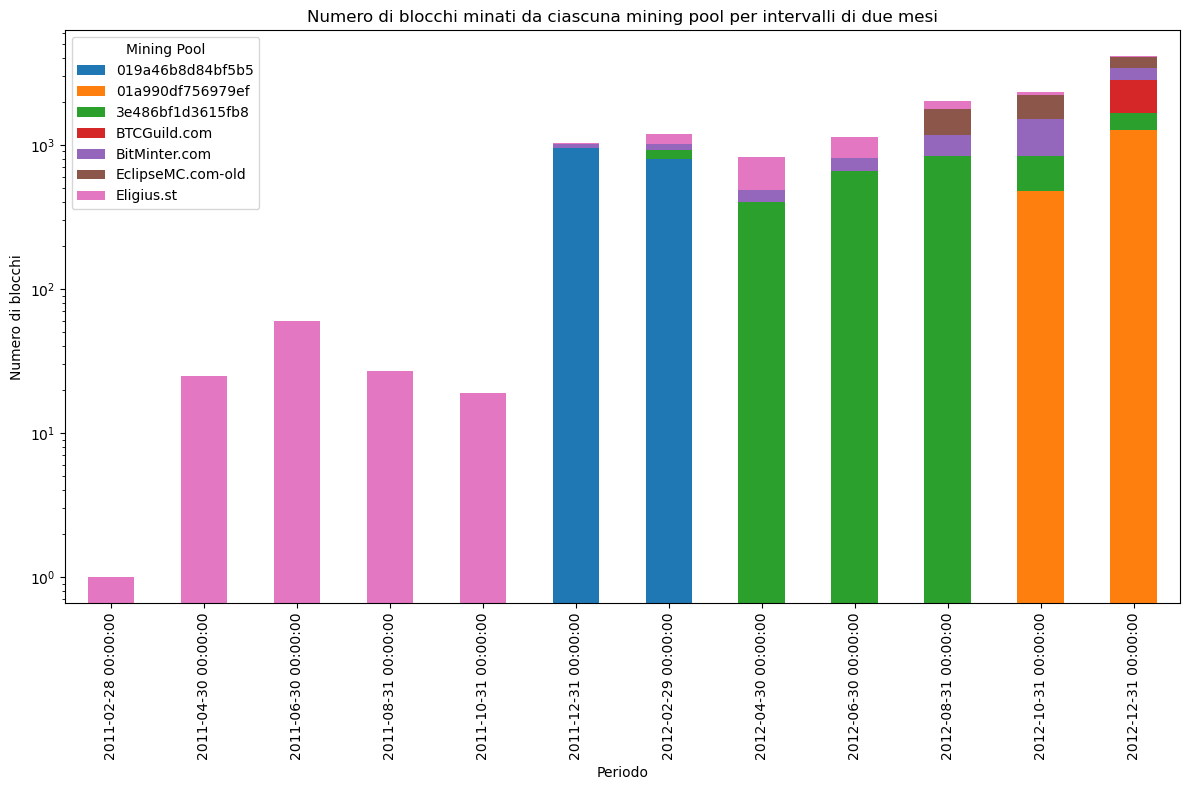

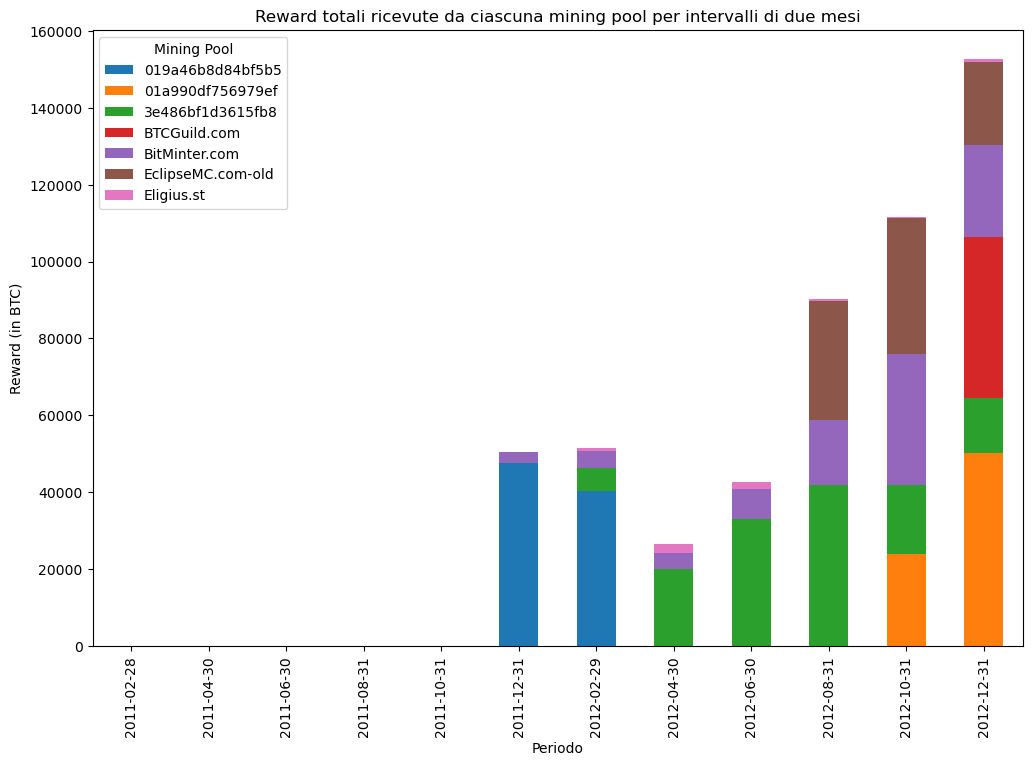

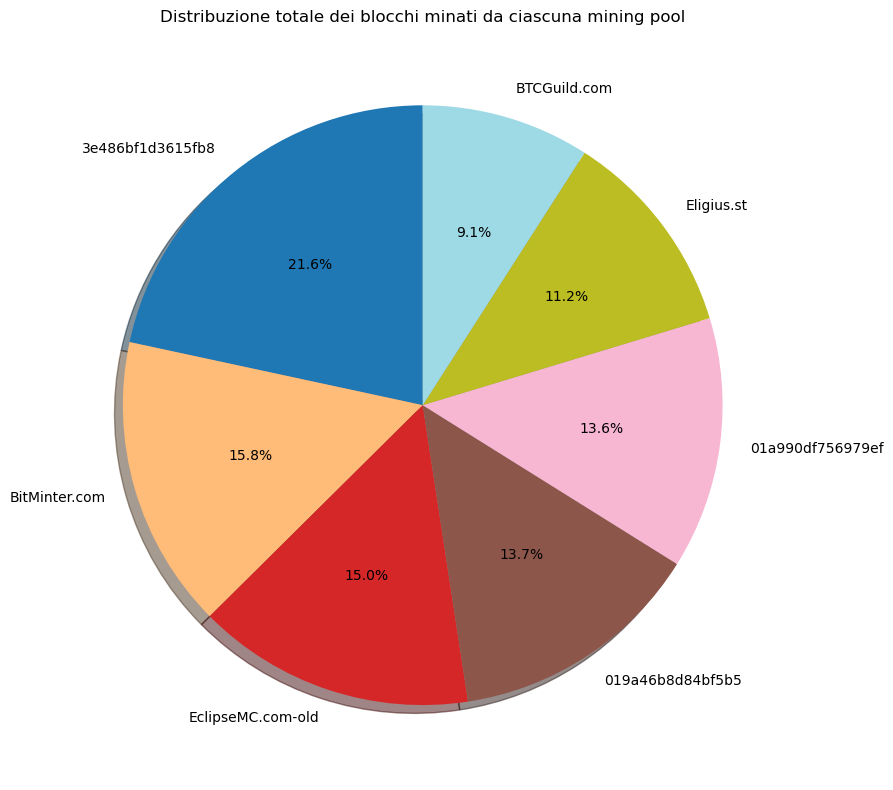

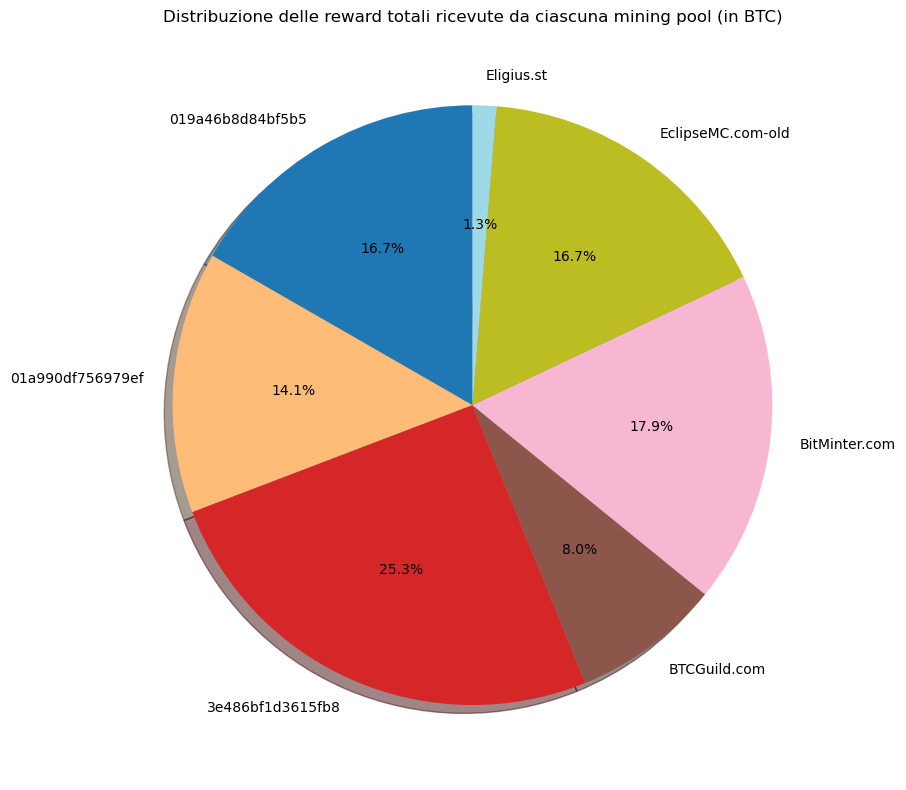

In [11]:
# Visualizzare il numero di blocchi minati per intervalli di due mesi
ax = blocks_by_period.plot(kind='bar', stacked=True, figsize=(12, 8))
#blocks_by_period.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Numero di blocchi minati da ciascuna mining pool per intervalli di due mesi')
plt.xlabel('Periodo')
plt.ylabel('Numero di blocchi')
plt.legend(title='Mining Pool')
ax.set_yscale('log')
plt.tight_layout()
plt.show()


# Grafico delle reward per intervalli di due mesi
rewards_by_period.index = rewards_by_period.index.astype(str)  # Convertire in stringa per visualizzare i periodi
ax = rewards_by_period.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Reward totali ricevute da ciascuna mining pool per intervalli di due mesi')
plt.xlabel('Periodo')
plt.ylabel('Reward (in BTC)')
plt.legend(title='Mining Pool')


# Global pie chart for the number of blocks mined by each mining pool
plt.figure(figsize=(12, 8))
global_blocks.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='tab20', shadow=True)
plt.title('Distribuzione totale dei blocchi minati da ciascuna mining pool')
plt.ylabel('')  # Hide the y-label
plt.tight_layout()
plt.show()

# Global pie chart for the total rewards received by each mining pool
plt.figure(figsize=(12, 8))
global_rewards.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='tab20' , shadow=True)
plt.title('Distribuzione delle reward totali ricevute da ciascuna mining pool (in BTC)')
plt.ylabel('')  # Hide the y-label
plt.tight_layout()
plt.show()


Per visualizzare il numero di blocchi minati e le relative ricompense ogni due mesi, utilizzo un grafico a barre con l'opzione "stacked" impostata su True.
In questo modo, le barre vengono impilate, offrendo una rappresentazione visiva più chiara del contributo di ciascuna mining pool per ogni bimestre.
Nel primo grafico, che mostra il numero di blocchi minati, si può osservare come l'andamento di certe mining pool sia crescente o decrescente in determinati periodi.
Ad esempio, si nota che la mining pool identificata con __01a9__ inizia ad essere utilizzata negli ultimi due mesi del 2012.
Al contempo, si vedono mining pools che sono costantemente attive, come __Eligius__, la quale, pur essendo meno utilizzata nell'ultimo periodo, rimane presente.
Questo ci indica che le mining pool con strategie di localizzazione dei nodi più efficaci e/o con maggiori risorse possiedono un effettivo vantaggio.
Tali informazioni possono essere utili per decidere dove allocare risorse in futuro, basandosi su tendenze passate.

Il secondo grafico mostra la distribuzione delle ricompense, evidenziando variazioni significative tra i vari mesi.
Questo suggerisce che fattori come la tecnologia di mining, il prezzo della criptovaluta e la difficoltà del processo di mining influiscono notevolmente. 
Questi dati sono preziosi perché permettono alle mining pool di rivedere e ottimizzare le loro strategie operative.

# Percorso dei bitcoin
L'ultima cosa che ci viene chiesta è quella di tracciare un percorso dei bitcoin considerando al massimo k passi e partendo da una coinbase __Eligius__ che ha __c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6__ come hash della transazione.
Quindi partendo dalla transazione recupero i suoi output e da questi output rifaccio la stessa cosa, cosi facendo creo un grafo.
L'implementazione fornita si basa su due funzioni principali: __impostagrafo__ e __stampa__.
__Impostagrafo__, prende in input l'id della transazione, crea l'user agent e imposta l'header.
Poi controlla di avere proxy a disposizione e se li ha fa una request per prendere il codice html del url che ha creato, dopodiche parsa il codice e per ogni riga in output che trova, prende l'address e il link alla prossima transazione.
Infine ritorna la lista creata.

Mentre la seconda funzione, __stampa__, si limita a creare un grafo e definire una coda inizalmente popolata dalla transazione di partenza, la profondita massima ancora disponibile, e il predecessore.
Poi per ogni elemento della lista, inizia a controllare se l'ha gia visitato oppure se la profondita va ancora bene, se passa questi controlli allora chiama impsotagrafo sulla transazione e fa una map che andra a popolare e poi aggiungere dati alla coda.
Infine ritorna il grafo.

In [12]:
def impostagrafo(txid):
    url = f"https://www.walletexplorer.com/txid/{txid}"
    user_agent = UserAgent().random
    headers = {'User-Agent': user_agent}
    transaction = []  # List to store edges

    if len(proxies) == 0:
        #print("Numero massimo di proxy bloccati raggiunto. Terminazione.")
        raise StopIteration

    proxy = random.choice(proxies)

    try:
        response = requests.get(url, headers=headers, proxies=proxy)
        if response.text.startswith("Too"):
            proxies.remove(proxy)
            #print(f"WalletExplorer ha bloccato l'IP del proxy. Cambio proxy... (numero di proxy rimanenti alla sospensione dell'esecuzione: {len(proxies)})")
            time.sleep(5)
            return impostagrafo(txid)

        soup = BeautifulSoup(response.text, 'html.parser')
        output = soup.select("table.tx tr:nth-child(2) td:nth-child(2) table.empty tr")
        if output:
            for nodi in output:
                address_link = nodi.find('a', href=True)
                next_tx_link = nodi.find('td', class_='small').find('a', href=True)
                bt = nodi.find('td', string=lambda x: 'BTC' in x if x else False)  # Trova il td che contiene 'BTC'
                if address_link and next_tx_link:
                    address = address_link.text.strip()
                    next_txid = next_tx_link['href'].split('/')[-1]
                    bt = bt.text.replace(' ', '').replace('BTC', '').strip()
                    transaction.append((address, next_txid, bt))

    except Exception as e:
        print(f"Errore durante la richiesta: {e}")
        proxies.remove(proxy)
        print(f"Errore durante la richiesta. Cambio proxy... (numero di proxy rimanenti: {len(proxies)})")
        time.sleep(10)
        
    return transaction


In [13]:
def stampa(start_txid, k):
    graph = nx.DiGraph()
    queue = [(start_txid, k, [], None)]
    visited = set()
    
    while queue:
        current_txid, depth, prev_addresses, prev_bt = queue.pop(0)
        
        if current_txid in visited or depth < 0:
            continue
        
        visited.add(current_txid)
        transactions = impostagrafo(current_txid)
        next_address_map = {}
        
        for address, next_txid, bt in transactions:
            if next_txid not in next_address_map:
                next_address_map[next_txid] = []
            next_address_map[next_txid].append((address, bt))
        
        for next_txid, addr_bt_pairs in next_address_map.items():
            for address, bt in addr_bt_pairs:
                graph.add_node(address, label=address[:4])
                for prev_address in prev_addresses:
                    graph.add_edge(prev_address, address, weight=bt)
                queue.append((next_txid, depth - 1, [address], bt))
    
    return graph

In [14]:
G = stampa("c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6", k)

Quindi ora costruiamo l'albero impostando dimensione e colore dei nodi e delle etichette.
Creo un grafo A diretto con pygraphiz dell’oggetto NetworkX G, come layout uso dot.
Il parametro strict = True  assicura che il grafo non abbia più di un arco tra la stessa coppia di nodi, mentre direct lo rende diretto.
Poi imposto l'albero da sinistra verso destra con il parametro rankdir e infine salvo in formato png

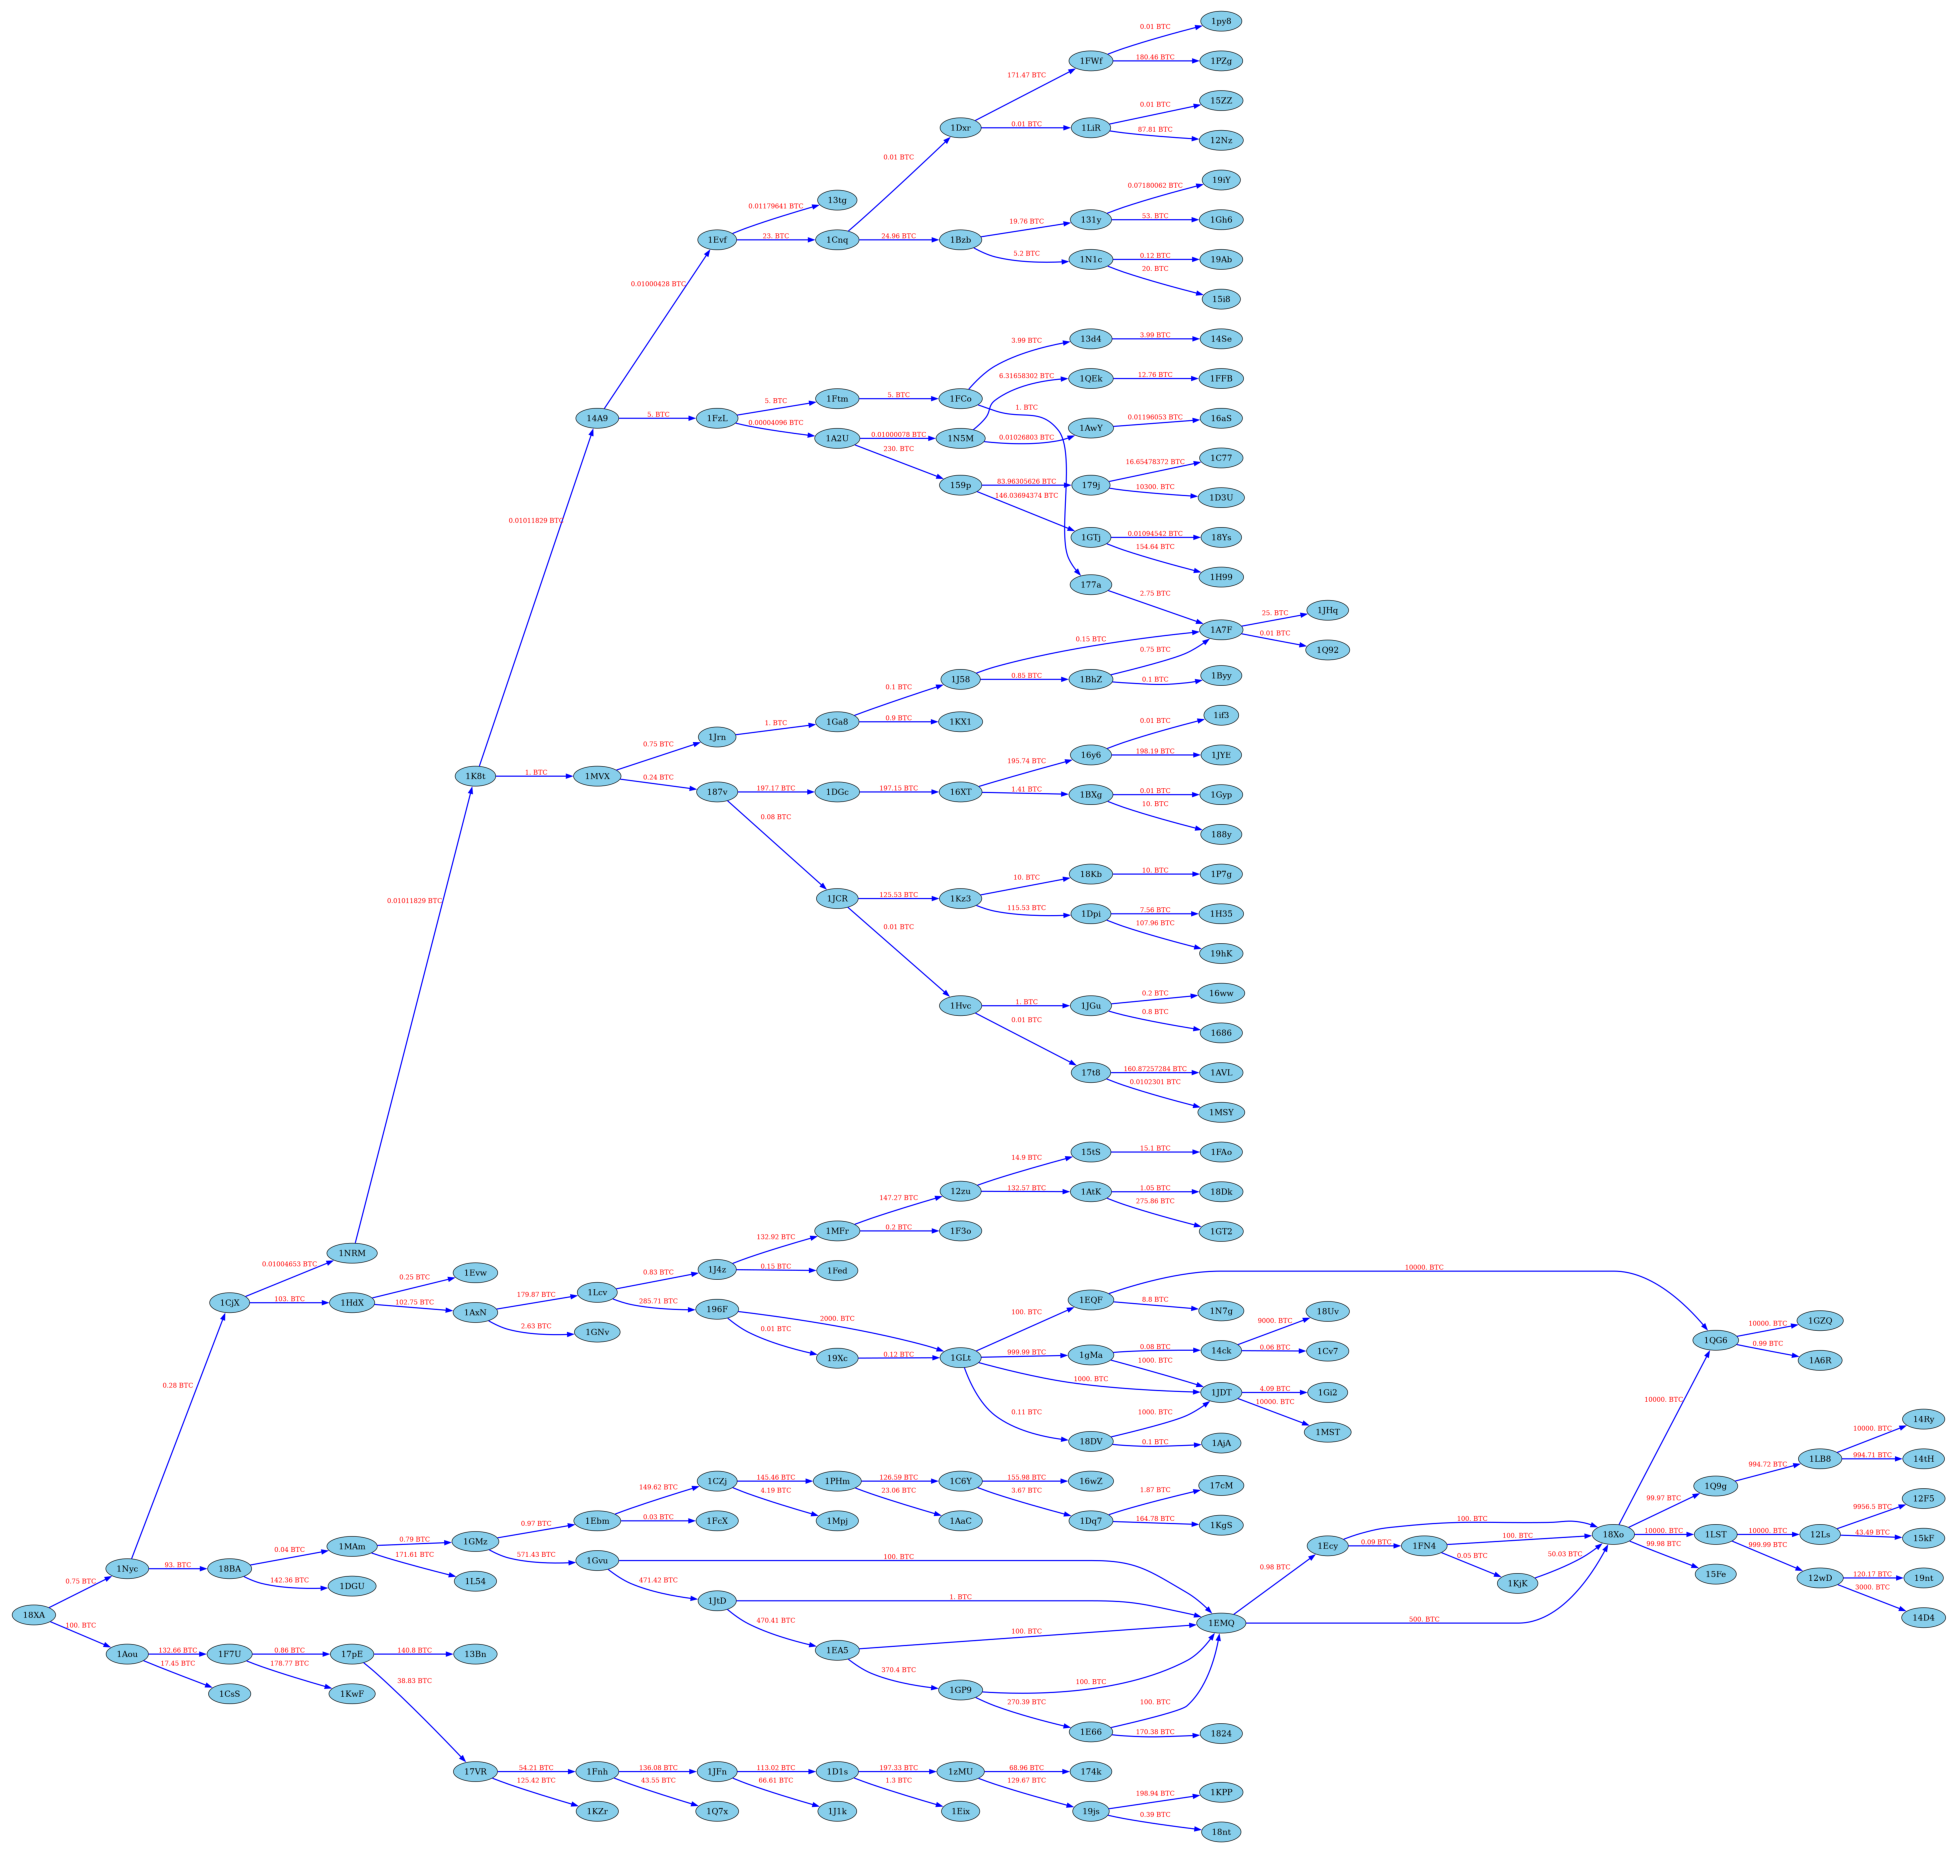

In [15]:
A = pgv.AGraph(strict=True, directed=True, rankdir="LR")
A.graph_attr.update(nodesep='0.5')

# Aggiungo nodi e archi ad A con attributi aggiornati
for node in G.nodes():
    # Uso solo le prime 4 cifre per l'etichetta del nodo
    A.add_node(node, label=node[:4], style='filled', fillcolor='#87ceeb', shape='ellipse', fontsize='15')
for u, v, data in G.edges(data=True):
    btc_value = data.get('weight', '0')  # Ottieni il valore BTC dal peso dell'arco
    A.add_edge(u, v, color='#0000ff', penwidth=2, label=f"{btc_value} BTC", fontsize='12', fontcolor='#ff0000')
# Applica il layout e disegna il grafo
A.layout(prog='dot')
A.draw('grafo.png')

# Carica immagine del grafo con 'imread'
img = plt.imread('grafo.png')
plt.figure(figsize=(25, 40))
plt.imshow(img)
plt.axis('off')
plt.show()

Grazie a questa struttura ad albero è facile tracciare il percorso della transazione dalla sorgente fino alle destinazioni.

# Statistiche sui dati
Possiamo vedere dati interessanti con la centralità

## Di grado:
Serve per misurare a quanti nodi un nodo è collegato dirratamente, normalizzato rispetto al numero massimo possibile di connessioni che potrebbe avere.
Se un nodo ha alta centralita nel contesto dei bitcoin, allora potrebbe significare che è presente in tante transazioni, non importa se mittente o destinatario.
Ovviamente questi nodi sono importanti, e possiamo vedere che l'asse delle y è normalizzata tra 0 e 1, mentre su quella delle x ci sono i singoli nodi.
Osservando il grafico si nota che la maggior parte dei nodi ha un basso grado (inferiore a 0.02). 
Tuttavia, esistono alcuni nodi che superano lo 0.04, identificabili come nodi centrali o hub. 
Questi nodi sono cruciali per la rete, poiché connettono un numero significativo di altri nodi e facilitano molte transazioni.
Per calcolarli semplicemente chiamo la funzione degree_centrality e mi ritornerà un dizionario nodo : valore di centralita.

## Di intermediazione
Serve a misurare quanto un nodo appare nel percorso minimo di coppie di nodi in una rete.
Un nodo con un alto valore è molto importante, visto che potrebbe influenzare il passaggio dei bitcoin tra diverse aree della rete.
Anche qua l'asse delle y mostra valori tra 0 e 1, indicando la percentuale di cammini minimi che attraversano un determinato nodo.
Nodi con valori elevati sono essenziali per la rete, in quanto fungono da ponti per molte transazioni, facilitando la connettività e la robustezza della rete stessa.
Per calcolarli semplicemente chiamo la funzione betweenness_centrality e mi ritornerà un dizionario nodo : valore di centralita.

## Di closeness
La centralità di closeness misura quanto un nodo è vicino a tutti gli altri nodi della rete.
Un nodo con alta centralità di closeness può diffondere informazioni rapidamente in tutta la rete. 
Nel contesto dei bitcoin, un nodo con alta centralità di closeness potrebbe essere fondamentale per la propagazione rapida di transazioni o informazioni.
Dal grafico possiamo notare che tutti si aggirano verso 0.010 tranne qualche picco che sale fino a 0.035.
Per calcolarli semplicemente chiamo la funzione closeness_centrality e mi ritornerà un dizionario nodo : valore di closeness.

## Di eigenvector
La centralità di eigenvector misura l'influenza di un nodo in una rete, considerando non solo il numero di connessioni dirette (come la centralità di grado), ma anche l'importanza dei nodi a cui è collegato.
Nel contesto dei bitcoin, un nodo con alta centralità di eigenvector potrebbe essere parte di un cluster di nodi influenti, facilitando transazioni con altri nodi altrettanto influenti.
Dal grafico possiamo vedere come ci siano pochi picchi, e il resto valori prossimi allo zero.
Per calcolarli semplicemente chiamo la funzione eigenvector_centrality e mi ritornerà un dizionario nodo : valore di eigenvector.


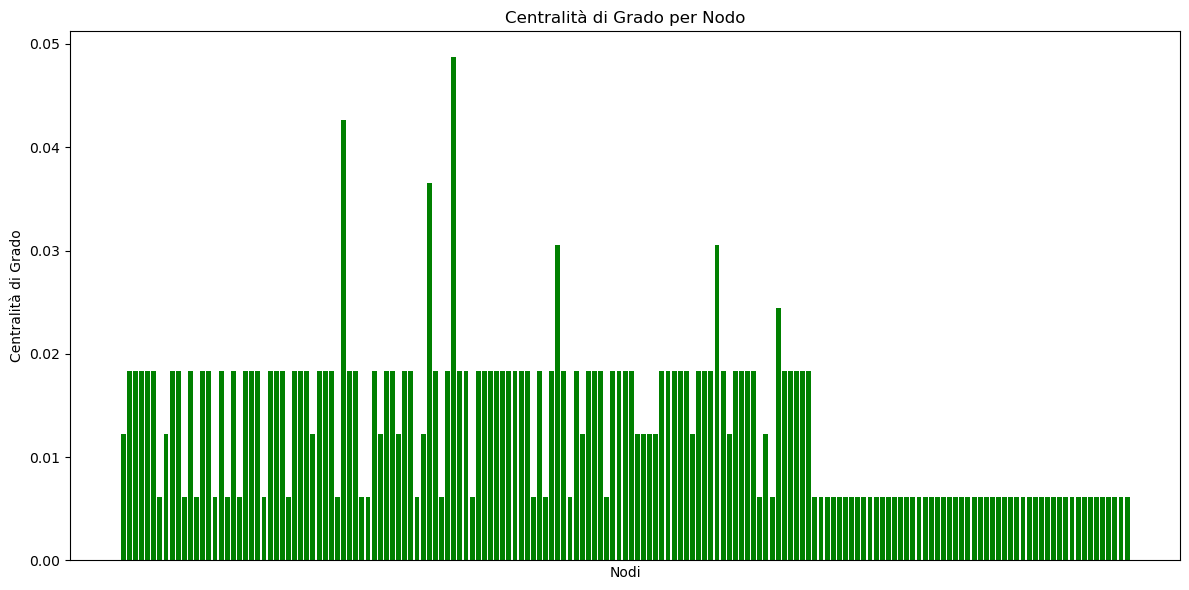

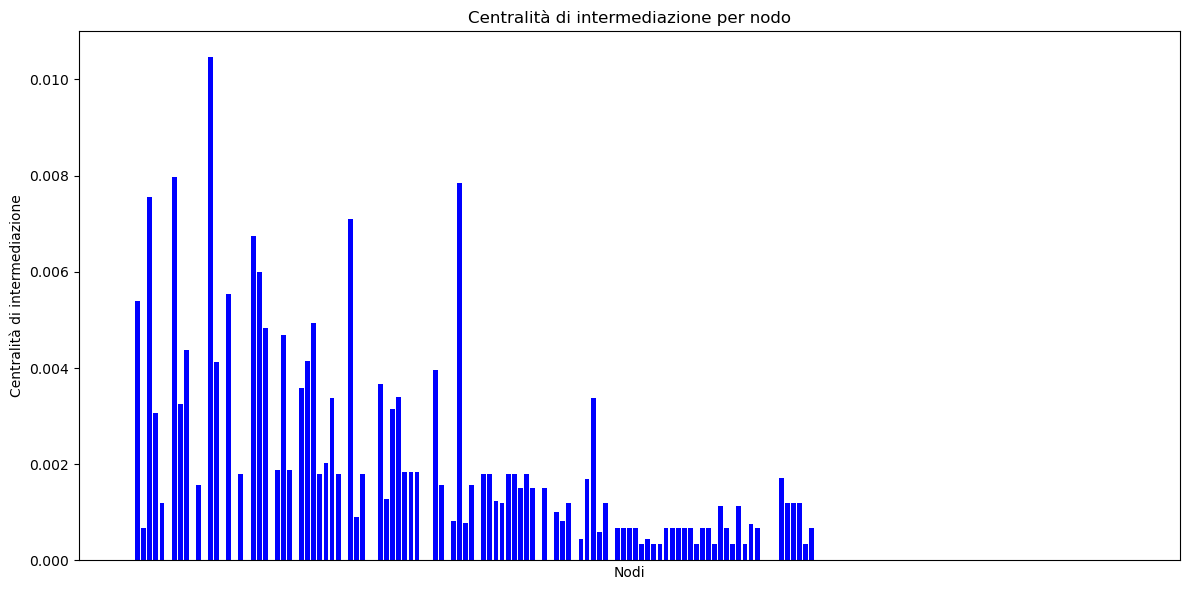

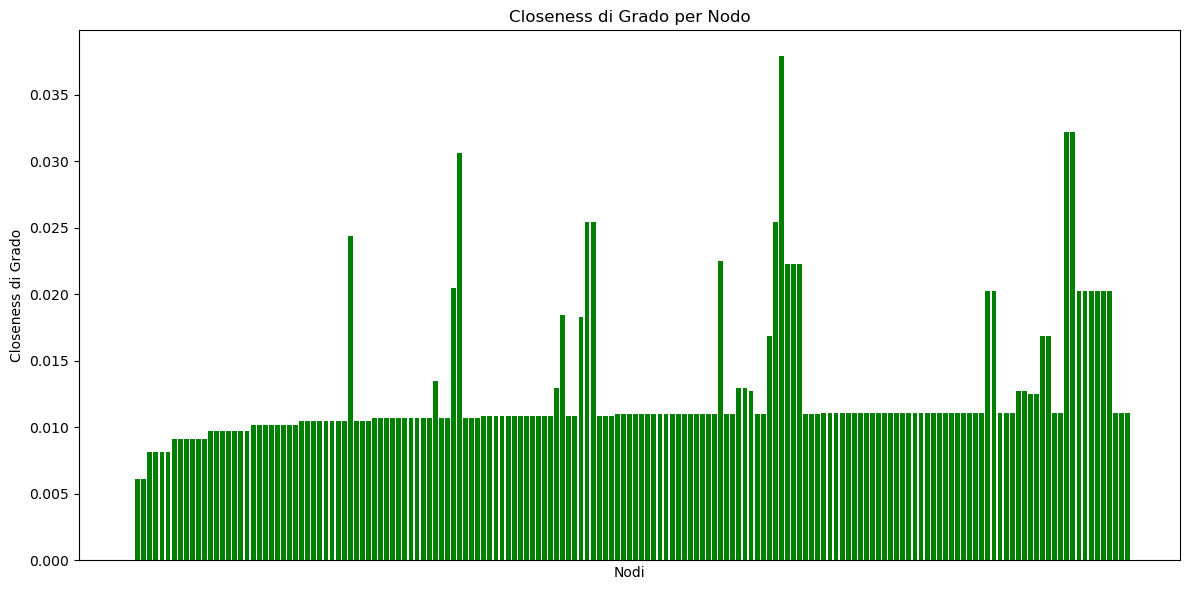

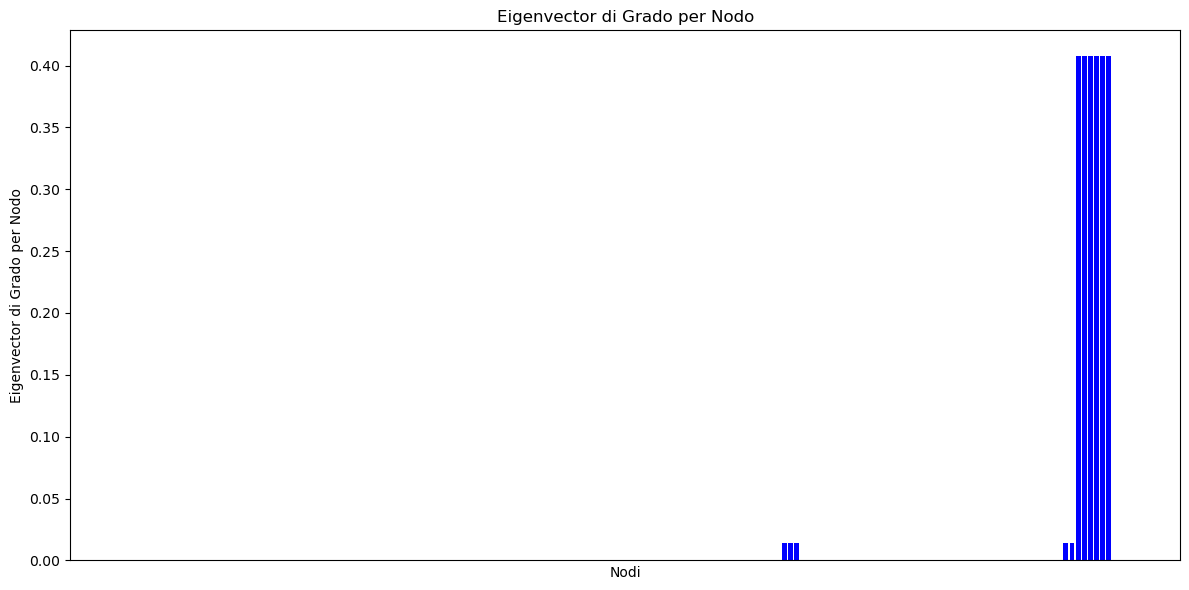

In [16]:
def plot_centralities(G, centralities, title, ylabel, color):
    nodes = list(G.nodes())
    centrality_values = [centralities[node] for node in nodes]
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(nodes)), centrality_values, color=color)
    plt.xlabel('Nodi')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks([])
    plt.tight_layout()
    plt.show()

# Calcolo delle centralità
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G , max_iter=500)



# Plot delle centralità di grado
plot_centralities(G, degree_centrality, 'Centralità di Grado per Nodo', 'Centralità di Grado', 'green')

# Plot delle centralità di intermediazione
plot_centralities(G, betweenness_centrality, 'Centralità di intermediazione per nodo', 'Centralità di intermediazione', 'blue')

# Plot delle centralità di grado
plot_centralities(G, closeness_centrality, 'Closeness di Grado per Nodo', 'Closeness di Grado', 'green')

# Plot delle centralità di intermediazione
plot_centralities(G, eigenvector_centrality, 'Eigenvector di Grado per Nodo', 'Eigenvector di Grado per Nodo', 'blue')